# Free particle Langevin dynamics

In [1]:
import openmm as mm
from openmm import app
from openmm import unit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Definición del sistema.

n_particles = 1
mass = 100 * unit.amu

In [3]:
# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [4]:
# Definición del estado termodinámico y el integrador.

step_size = 0.01*unit.picoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [5]:
# Creación de la plataforma.

platform_name = 'CUDA' # O 'CPU' si no tienes gpu
platform = mm.Platform.getPlatformByName(platform_name)

In [6]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [7]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [8]:
# Parámetros de la simulación.

simulation_time = 10.0*unit.nanosecond
saving_time = 1.0*unit.picoseconds

In [9]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [10]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.nanometers
velocities = np.zeros([n_periods, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
potential_energies   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

In [11]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)

times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [12]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:15<00:00, 660.77it/s]


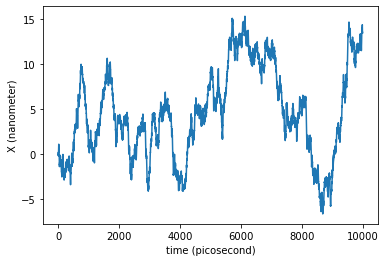

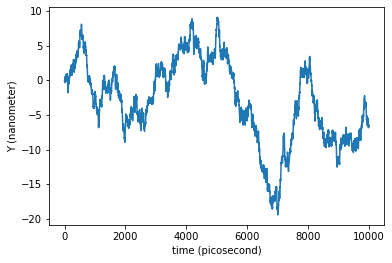

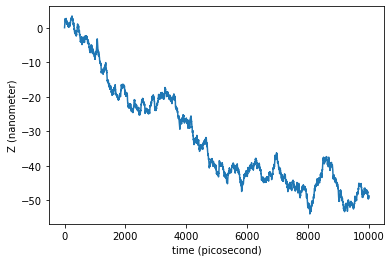

In [13]:
#Graficando las posiciones de cada dirección contra el tiempo

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

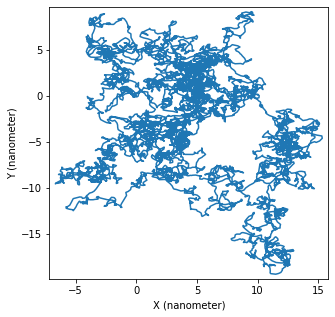

In [18]:
#Graficando la trayectoria de la partículo proyectada en el plano X Y

plt.rcParams['figure.figsize'] = 5, 5

plt.plot(positions[:,0,0], positions[:,0,1])
plt.xlabel('X ({})'.format(positions.unit))
plt.ylabel('Y ({})'.format(positions.unit))
plt.xlim([positions[:,0,0].min()._value-0.5, positions[:,0,0].max()._value+0.5])
plt.ylim([positions[:,0,1].min()._value-0.5, positions[:,0,1].max()._value+0.5])
plt.show()

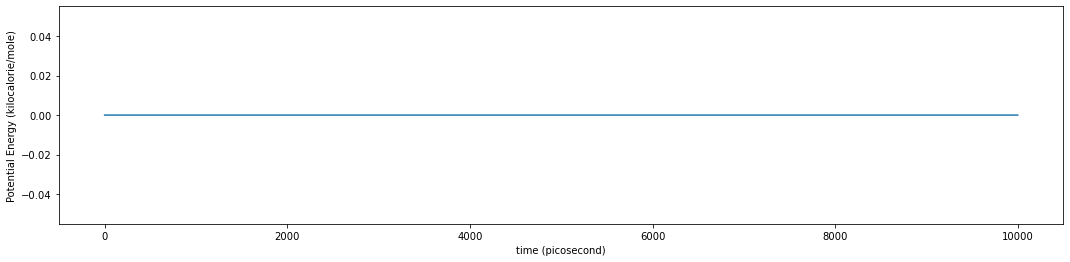

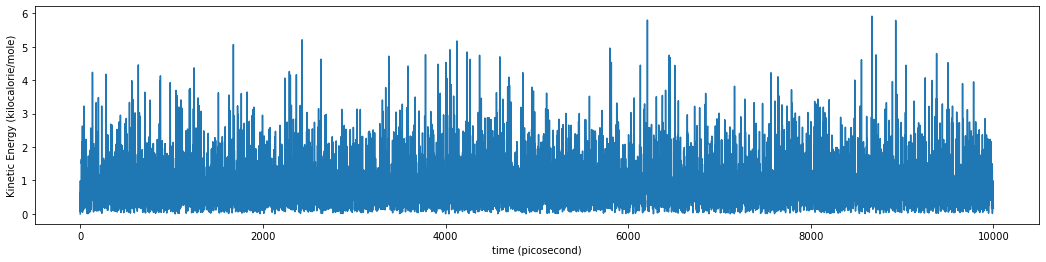

In [19]:
#Graficando la energía potencial y la energía cinética

plt.rcParams['figure.figsize'] = 18, 4

plt.plot(times, potential_energies[:])
plt.ylabel('Potential Energy ({})'.format(potential_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()

plt.plot(times, kinetic_energies[:])
plt.ylabel('Kinetic Energy ({})'.format(kinetic_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()

In [22]:
#Sacando el promedio de la Energía cinética
suma_kinetic = 0
for i in range(len(kinetic_energies.value_in_unit(unit.kilocalories_per_mole))):
    suma_kinetic = suma_kinetic + kinetic_energies.value_in_unit(unit.kilocalories_per_mole)[i]

promedio_kinetic = suma_kinetic / len(kinetic_energies[:])
print("El promedio de la Energía cinética <Ec> es " + str(round(promedio_kinetic,2)))

El promedio de la Energía cinética <Ec> es 0.89
